In [1]:
#%pip install wordcloud
#%pip uninstall numpy
#%pip install numpy==1.23.5
#%pip install surprise

In [2]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
import time
import spacy
import re
from collections import Counter
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
#--------------------------------------------------------------#
# SECTION 1: DATA LOADING AND EXPLORATION
#--------------------------------------------------------------#
print("SECTION 1: DATA LOADING AND EXPLORATION")

# Load the dataset
with open('Appliances.jsonl\Appliances.jsonl', 'r') as f:
    appliances = [json.loads(line) for line in f]

df = pd.DataFrame(appliances)
print(f"Dataset shape: {df.shape}")

SECTION 1: DATA LOADING AND EXPLORATION
Dataset shape: (2128605, 10)


In [4]:
# Create a stratified sample of the data to make processing more manageable
stratify_col = 'rating'

# Ensure the column exists
if stratify_col in df.columns:
    split = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=50)
    for _, sample_idx in split.split(df, df[stratify_col]):
        stratified_df = df.iloc[sample_idx]
    print(f"Stratified sample shape: {stratified_df.shape}")
    print(f"Class distribution in sample:\n{stratified_df[stratify_col].value_counts(normalize=True)}")
else:
    print(f"Column '{stratify_col}' not found in DataFrame.")

df = stratified_df

Stratified sample shape: (10000, 10)
Class distribution in sample:
rating
5.0    0.6982
1.0    0.1177
4.0    0.0978
3.0    0.0489
2.0    0.0374
Name: proportion, dtype: float64


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 383158 to 376648
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             10000 non-null  float64
 1   title              10000 non-null  object 
 2   text               10000 non-null  object 
 3   images             10000 non-null  object 
 4   asin               10000 non-null  object 
 5   parent_asin        10000 non-null  object 
 6   user_id            10000 non-null  object 
 7   timestamp          10000 non-null  int64  
 8   helpful_vote       10000 non-null  int64  
 9   verified_purchase  10000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 791.0+ KB


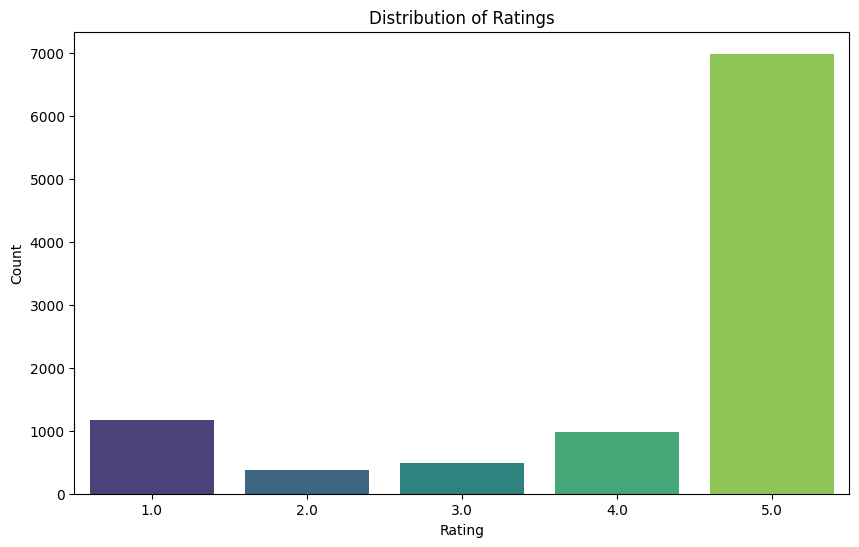


Summary statistics:
          timestamp  helpful_vote
count  1.000000e+04  10000.000000
mean   1.561667e+12      0.900000
std    8.590966e+10      9.512048
min    1.169425e+12      0.000000
25%    1.502385e+12      0.000000
50%    1.578846e+12      0.000000
75%    1.627794e+12      0.000000
max    1.693184e+12    657.000000


In [5]:
# Display basic information about the dataset
df.info()

# Convert rating to categorical
df['rating'] = df['rating'].astype('object')

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Get summary statistics
print("\nSummary statistics:")
print(df.describe())


SECTION 2: ANALYZING REVIEWS BY PRODUCTS AND USERS


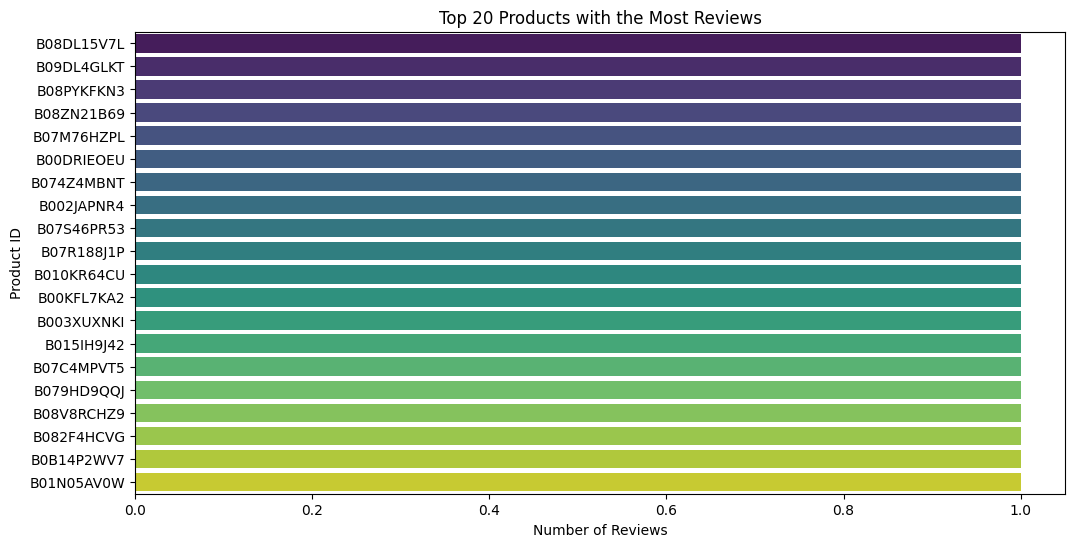

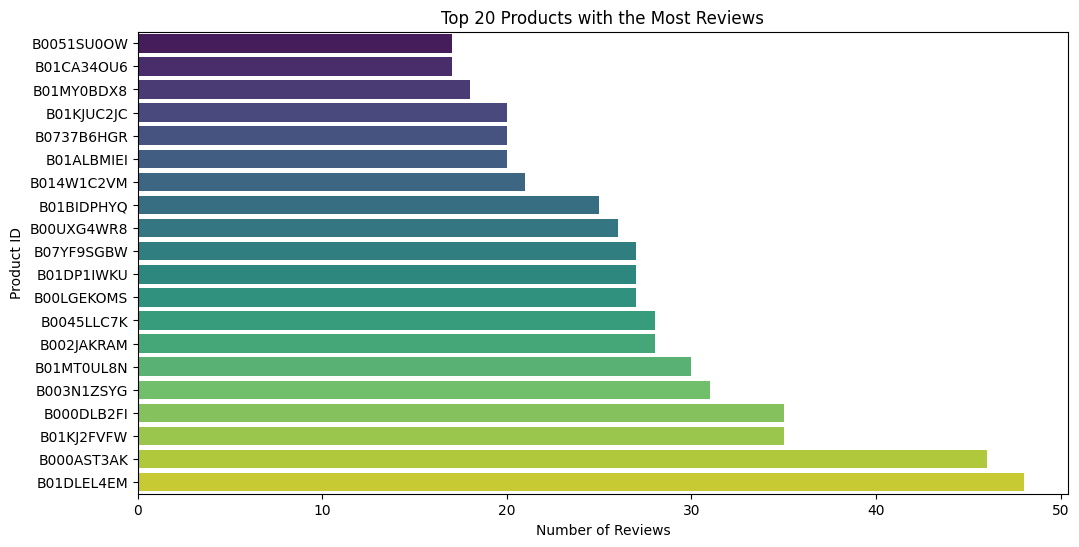

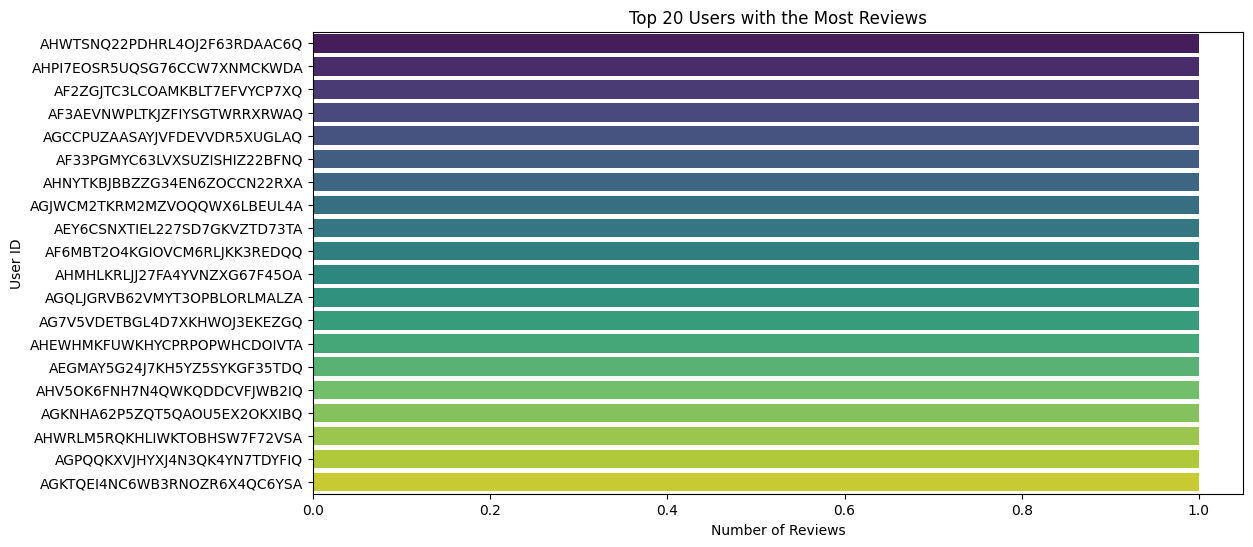

In [6]:
#--------------------------------------------------------------#
# SECTION 2: ANALYZING REVIEWS BY PRODUCTS AND USERS
#--------------------------------------------------------------#
print("\nSECTION 2: ANALYZING REVIEWS BY PRODUCTS AND USERS")

# Distribution of the number of reviews per product
reviews_per_product = df['asin'].value_counts().reset_index()
reviews_per_product.columns = ['product_id', 'num_reviews']
reviews_per_product = reviews_per_product.sort_values(by='num_reviews', ascending=False)

# Get top 20 products
top_20_products = reviews_per_product.tail(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_20_products, x='num_reviews', y='product_id', palette='viridis')
plt.title('Top 20 Products with the Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Product ID')
plt.show()

# Also show products sorted in ascending order
reviews_per_product = df['asin'].value_counts().reset_index()
reviews_per_product.columns = ['product_id', 'num_reviews']
reviews_per_product = reviews_per_product.sort_values(by='num_reviews', ascending=True)

# Get top 20 products
top_20_products = reviews_per_product.tail(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_20_products, x='num_reviews', y='product_id', palette='viridis')
plt.title('Top 20 Products with the Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Product ID')
plt.show()

# Distribution of reviews per user
reviews_per_user = df['user_id'].value_counts().reset_index()
reviews_per_user.columns = ['user_id', 'num_reviews']
reviews_per_user = reviews_per_user.sort_values(by='num_reviews', ascending=True)

# Get top 20 users
top_20_users = reviews_per_user.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_20_users, x='num_reviews', y='user_id', palette='viridis')
plt.title('Top 20 Users with the Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('User ID')
plt.show()


SECTION 3: WORD CLOUD VISUALIZATION BY SENTIMENT


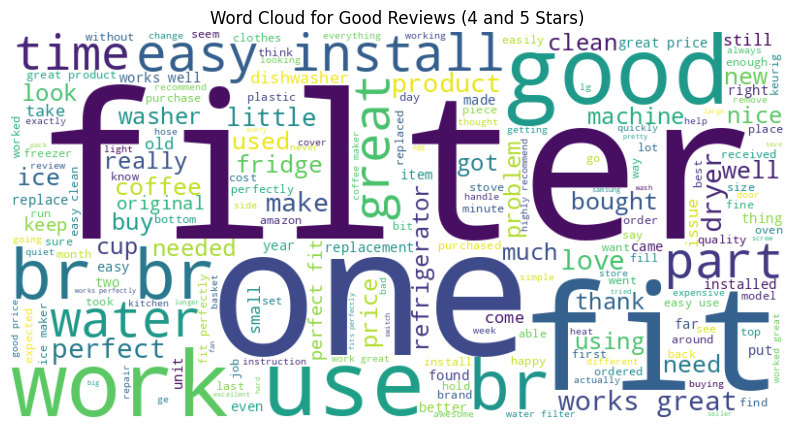

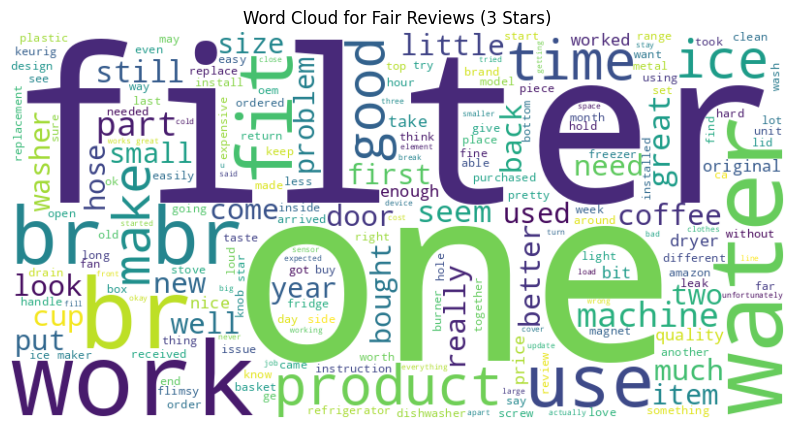

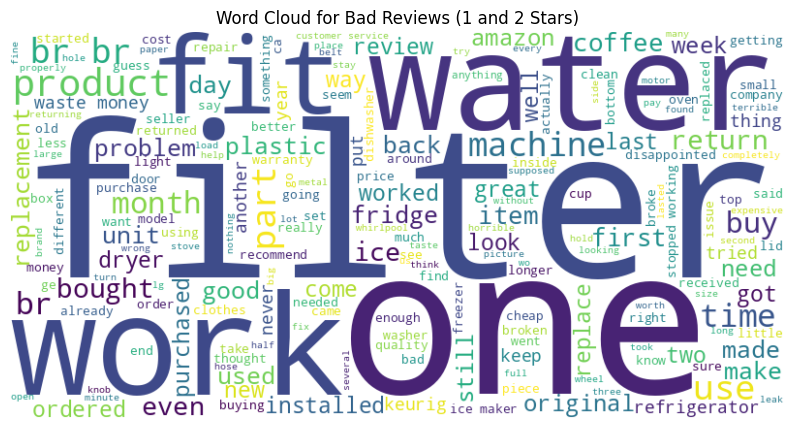

In [7]:
#--------------------------------------------------------------#
# SECTION 3: WORD CLOUD VISUALIZATION BY SENTIMENT
#--------------------------------------------------------------#
print("\nSECTION 3: WORD CLOUD VISUALIZATION BY SENTIMENT")

# Categorize reviews by rating
good_reviews = df[df['rating'].isin([4, 5])]['text'].tolist()
fair_reviews = df[df['rating'] == 3]['text'].tolist()
bad_reviews = df[df['rating'].isin([1, 2])]['text'].tolist()

# Get stopwords
stop_words = set(stopwords.words('english'))

# Create word cloud for good reviews
good_reviews_text = ' '.join(good_reviews)
good_reviews_tokens = word_tokenize(good_reviews_text.lower())
good_reviews_tokens = [word for word in good_reviews_tokens if word.isalpha() and word not in stop_words]
good_reviews_text = ' '.join(good_reviews_tokens)

wordcloud_good = WordCloud(width=800, height=400, background_color='white').generate(good_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Good Reviews (4 and 5 Stars)')
plt.show()

# Create word cloud for fair reviews
fair_reviews_text = ' '.join(fair_reviews)
fair_reviews_tokens = word_tokenize(fair_reviews_text.lower())
fair_reviews_tokens = [word for word in fair_reviews_tokens if word.isalpha() and word not in stop_words]
fair_reviews_text = ' '.join(fair_reviews_tokens)

wordcloud_fair = WordCloud(width=800, height=400, background_color='white').generate(fair_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_fair, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fair Reviews (3 Stars)')
plt.show()

# Create word cloud for bad reviews
bad_reviews_text = ' '.join(bad_reviews)
bad_reviews_tokens = word_tokenize(bad_reviews_text.lower())
bad_reviews_tokens = [word for word in bad_reviews_tokens if word.isalpha() and word not in stop_words]
bad_reviews_text = ' '.join(bad_reviews_tokens)

wordcloud_bad = WordCloud(width=800, height=400, background_color='white').generate(bad_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Bad Reviews (1 and 2 Stars)')
plt.show()

In [8]:
#--------------------------------------------------------------#
# SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS
#--------------------------------------------------------------#
print("\nSECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS")

# Map ratings to sentiment labels
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x in [4, 5] else ('neutral' if x == 3 else 'negative'))

# Print class distribution
sentiment_counts = df['sentiment'].value_counts()
print("\nSentiment distribution:")
print(sentiment_counts)
print(f"Percentage of positive: {sentiment_counts['positive']/len(df)*100:.2f}%")
print(f"Percentage of neutral: {sentiment_counts['neutral']/len(df)*100:.2f}%")
print(f"Percentage of negative: {sentiment_counts['negative']/len(df)*100:.2f}%")

# Split data into training and testing sets
X = df['text']
y = df['sentiment']

# Use stratified sampling to maintain class distribution
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")


SECTION 4: DATA PREPARATION FOR SENTIMENT ANALYSIS

Sentiment distribution:
sentiment
positive    7960
negative    1551
neutral      489
Name: count, dtype: int64
Percentage of positive: 79.60%
Percentage of neutral: 4.89%
Percentage of negative: 15.51%

Training set size: 7000
Testing set size: 3000



SECTION 5: BASELINE MODEL - LOGISTIC REGRESSION
Training Logistic Regression model...

Logistic Regression Performance:
              precision    recall  f1-score   support

    negative       0.81      0.54      0.65       465
     neutral       0.50      0.01      0.01       147
    positive       0.88      0.99      0.93      2388

    accuracy                           0.87      3000
   macro avg       0.73      0.51      0.53      3000
weighted avg       0.85      0.87      0.84      3000

Accuracy: 0.8683333333333333


<Figure size 1000x800 with 0 Axes>

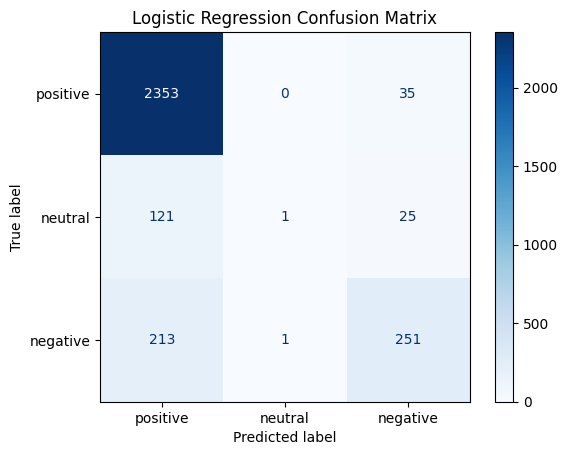


Sample Predictions from Logistic Regression Model:
Review: I received it in two days.  It was easily installed.  Oven is working and I'm baking.  Thanks for th...
True sentiment: positive
Predicted sentiment: positive
--------------------------------------------------------------------------------
Review: did not suck the water in to it,,,,...
True sentiment: negative
Predicted sentiment: negative
--------------------------------------------------------------------------------
Review: Really great product.  The rods are solid but really flexible. Works best in a drill.  Use only cloc...
True sentiment: positive
Predicted sentiment: positive
--------------------------------------------------------------------------------
Review: Bought these filters originally because the brand I normally used had doubled in price.  At first th...
True sentiment: negative
Predicted sentiment: negative
--------------------------------------------------------------------------------
Review: Love burner c

In [9]:
#--------------------------------------------------------------#
# SECTION 5: BASELINE MODEL - LOGISTIC REGRESSION
#--------------------------------------------------------------#
print("\nSECTION 5: BASELINE MODEL - LOGISTIC REGRESSION")

# Create and train the logistic regression pipeline
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

print("Training Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_lr, labels=['positive', 'neutral', 'negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'neutral', 'negative'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Sample predictions
print("\nSample Predictions from Logistic Regression Model:")
sample_indices = np.random.choice(range(len(X_test)), 5, replace=False)
for idx in sample_indices:
    text = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    pred_label = y_pred_lr[idx]
    print(f"Review: {text[:100]}...")  # Show first 100 chars
    print(f"True sentiment: {true_label}")
    print(f"Predicted sentiment: {pred_label}")
    print("-" * 80)

In [10]:
#--------------------------------------------------------------#
# SECTION 6: ASPECT-BASED SENTIMENT ANALYSIS FUNCTIONS
#--------------------------------------------------------------#
print("\nSECTION 6: ASPECT-BASED SENTIMENT ANALYSIS FUNCTIONS")

# Function to extract aspects (features) from reviews
def extract_aspects(reviews, top_n=20):
    """
    Extract common product aspects from reviews using frequency-based approach with NLTK
    
    Args:
        reviews: List of review texts
        top_n: Number of top aspects to extract
        
    Returns:
        List of most common aspects/features
    """
    print("Extracting aspects from reviews...")
    
    # Load spaCy model for better noun phrase extraction
    try:
        nlp = spacy.load('en_core_web_sm')
    except:
        # If model is not available, download it
        import subprocess
        subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
        nlp = spacy.load('en_core_web_sm')
    
    # Dictionary of product features commonly found in appliance reviews
    appliance_features = [
        'price', 'quality', 'value', 'size', 'weight', 'noise', 'power',
        'performance', 'design', 'durability', 'reliability', 'efficiency',
        'warranty', 'installation', 'cleaning', 'maintenance', 'temperature',
        'settings', 'controls', 'display', 'buttons', 'interface', 'features',
        'capacity', 'speed', 'cord', 'color', 'material', 'ease', 'convenience'
    ]
    
    # Extract noun phrases using spaCy
    all_aspects = []
    sample_size = min(len(reviews), 5000)  # Process a sample for efficiency
    
    for review in reviews[:sample_size]:
        if not isinstance(review, str) or len(review.strip()) == 0:
            continue
            
        doc = nlp(review.lower())
        
        # Extract noun chunks (potential aspects)
        for chunk in doc.noun_chunks:
            # Check if it contains any of our predefined appliance features
            for feature in appliance_features:
                if feature in chunk.text:
                    all_aspects.append(feature)
                    break
            
        # Also look for direct mentions of features
        for feature in appliance_features:
            if feature in review.lower():
                all_aspects.append(feature)
    
    # Count frequency of aspects
    aspect_counter = Counter(all_aspects)
    
    # Get top N most common aspects
    top_aspects = [aspect for aspect, count in aspect_counter.most_common(top_n)]
    
    print(f"Top {len(top_aspects)} aspects extracted: {', '.join(top_aspects)}")
    return top_aspects

# Function to analyze sentiment for each aspect in reviews
def analyze_aspect_sentiment(reviews, aspects):
    """
    Determine sentiment for each aspect in each review
    
    Args:
        reviews: List of review texts
        aspects: List of aspects to analyze
        
    Returns:
        DataFrame with sentiment scores for each aspect in each review
    """
    print("Analyzing sentiment for each aspect...")
    
    # Create a DataFrame to store aspect sentiment scores
    aspect_sentiments = pd.DataFrame(index=range(len(reviews)))
    
    # Process each review
    for idx, review in enumerate(reviews):
        if not isinstance(review, str) or len(review.strip()) == 0:
            # Skip empty reviews or non-string values
            for aspect in aspects:
                aspect_sentiments.loc[idx, aspect] = 0
            continue
            
        # Split review into sentences
        sentences = re.split(r'[.!?]+', review.lower())
        
        # Initialize sentiment scores for each aspect in this review
        aspect_scores = {aspect: [] for aspect in aspects}
        
        # Check each sentence for aspects
        for sentence in sentences:
            # Skip empty sentences
            if len(sentence.strip()) == 0:
                continue
                
            # Simple sentiment heuristic: count positive and negative words
            positive_words = ['good', 'great', 'excellent', 'awesome', 'nice', 'love', 'perfect', 'best']
            negative_words = ['bad', 'poor', 'terrible', 'horrible', 'worst', 'hate', 'disappointing', 'fail']
            
            # Calculate a simple sentiment score
            pos_count = sum(1 for word in positive_words if word in sentence.lower())
            neg_count = sum(1 for word in negative_words if word in sentence.lower())
            
            if pos_count > neg_count:
                sentence_sentiment = 1.0  # positive
            elif neg_count > pos_count:
                sentence_sentiment = -1.0  # negative
            else:
                sentence_sentiment = 0.0  # neutral
                
            # Check for each aspect in the sentence
            for aspect in aspects:
                if aspect in sentence:
                    aspect_scores[aspect].append(sentence_sentiment)
        
        # Calculate average sentiment for each aspect in this review
        for aspect in aspects:
            if aspect_scores[aspect]:
                # If we found the aspect, use the average sentiment
                aspect_sentiments.loc[idx, aspect] = np.mean(aspect_scores[aspect])
            else:
                # If aspect not mentioned, set to 0 (neutral)
                aspect_sentiments.loc[idx, aspect] = 0
    
    return aspect_sentiments

# Function to create enhanced feature vectors
def create_enhanced_features(reviews, aspect_sentiments):
    """
    Combine TF-IDF features with aspect sentiment features
    
    Args:
        reviews: List of review texts
        aspect_sentiments: DataFrame of aspect sentiment scores
        
    Returns:
        Enhanced feature matrix
    """
    print("Creating enhanced feature vectors...")
    
    # Create TF-IDF features from review text
    tfidf = TfidfVectorizer(max_features=5000)
    tfidf_features = tfidf.fit_transform(reviews)
    
    # Convert aspect sentiments to numpy array
    aspect_features = aspect_sentiments.values
    
    # Standardize the aspect features
    scaler = StandardScaler()
    aspect_features_scaled = scaler.fit_transform(aspect_features)
    
    # Combine TF-IDF and aspect sentiment features
    enhanced_features = np.hstack((tfidf_features.toarray(), aspect_features_scaled))
    
    print(f"Enhanced feature matrix shape: {enhanced_features.shape}")
    return enhanced_features, tfidf


SECTION 6: ASPECT-BASED SENTIMENT ANALYSIS FUNCTIONS



SECTION 7: ENHANCED SVM MODEL WITH ASPECT-BASED SENTIMENT
Extracting aspects from reviews...
Top 10 aspects extracted: price, quality, size, value, installation, ease, design, power, noise, color
Processing training set:
Analyzing sentiment for each aspect...
Processing test set:
Analyzing sentiment for each aspect...
Creating enhanced feature vectors for training set...
Creating enhanced feature vectors...
Enhanced feature matrix shape: (7000, 5010)
Creating enhanced feature vectors for test set...
Training SVM model with aspect-enhanced features...
SVM model training completed in 620.79 seconds

SVM Model Performance with Aspect-Based Features:
              precision    recall  f1-score   support

    negative       0.57      0.71      0.63       465
     neutral       0.18      0.33      0.23       147
    positive       0.95      0.86      0.90      2388

    accuracy                           0.81      3000
   macro avg       0.57      0.63      0.59      3000
weighted avg      

<Figure size 1000x800 with 0 Axes>

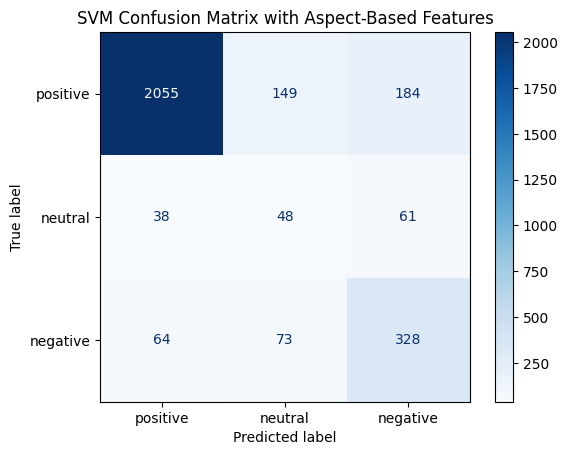


Sample Predictions from SVM Model:
Review: It’s a filter for the inside of the water system. My fridge was blinking that it was time to change ...
True sentiment: positive
Predicted sentiment: positive
--------------------------------------------------------------------------------
Review: It covers the gap well and looks like professionally installed. I literally spent few minutes to ins...
True sentiment: positive
Predicted sentiment: positive
--------------------------------------------------------------------------------
Review: These work fine in my coffee machine....
True sentiment: positive
Predicted sentiment: positive
--------------------------------------------------------------------------------
Review: We had low expectations for this off-brand, compact dishwasher. How wrong we were! This little fella...
True sentiment: positive
Predicted sentiment: positive
--------------------------------------------------------------------------------
Review: Bought these to replace Wal

In [11]:
#--------------------------------------------------------------#
# SECTION 7: SVM MODEL WITH ASPECT-BASED SENTIMENT
#--------------------------------------------------------------#
print("\nSECTION 7: ENHANCED SVM MODEL WITH ASPECT-BASED SENTIMENT")

# Extract common aspects from the training set
top_aspects = extract_aspects(X_train.values, top_n=10)

# Analyze sentiment for each aspect in training and test sets
print("Processing training set:")
train_aspect_sentiments = analyze_aspect_sentiment(X_train.values, top_aspects)
print("Processing test set:")
test_aspect_sentiments = analyze_aspect_sentiment(X_test.values, top_aspects)

# Create enhanced feature vectors
print("Creating enhanced feature vectors for training set...")
X_train_enhanced, tfidf_vectorizer = create_enhanced_features(X_train.values, train_aspect_sentiments)
print("Creating enhanced feature vectors for test set...")
X_test_enhanced = np.hstack((
    tfidf_vectorizer.transform(X_test.values).toarray(), 
    StandardScaler().fit_transform(test_aspect_sentiments.values)
))

# Train SVM model with enhanced features
print("Training SVM model with aspect-enhanced features...")
svm_start_time = time.time()

# Create SVM model with balanced class weights to address imbalance
svm_model = SVC(
    kernel='linear',
    C=1.0,
    class_weight='balanced',
    probability=True,
    random_state=42
)

# Train the model
svm_model.fit(X_train_enhanced, y_train)

# Calculate training time
svm_training_time = time.time() - svm_start_time
print(f"SVM model training completed in {svm_training_time:.2f} seconds")

# Make predictions
svm_y_pred = svm_model.predict(X_test_enhanced)

# Evaluate SVM model
print("\nSVM Model Performance with Aspect-Based Features:")
print(classification_report(y_test, svm_y_pred))
print("Accuracy:", accuracy_score(y_test, svm_y_pred))

# Plot confusion matrix for SVM
plt.figure(figsize=(10, 8))
svm_cm = confusion_matrix(y_test, svm_y_pred, labels=['positive', 'neutral', 'negative'])
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=['positive', 'neutral', 'negative'])
svm_disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('SVM Confusion Matrix with Aspect-Based Features')
plt.show()

# Sample predictions
print("\nSample Predictions from SVM Model:")
sample_indices = np.random.choice(range(len(X_test)), 5, replace=False)
for idx in sample_indices:
    text = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    pred_label = svm_y_pred[idx]
    print(f"Review: {text[:100]}...")  # Show first 100 chars
    print(f"True sentiment: {true_label}")
    print(f"Predicted sentiment: {pred_label}")
    print("-" * 80)


SECTION 8: MODEL COMPARISON
Model Comparison:
                      Model  Overall Accuracy  Neutral Precision  \
0       Logistic Regression          0.868333           0.500000   
1  SVM with Aspect Features          0.810333           0.177778   

   Neutral Recall  Neutral F1  Positive F1  Negative F1  
0        0.006803    0.013423     0.927291     0.646907  
1        0.326531    0.230216     0.904290     0.631985  


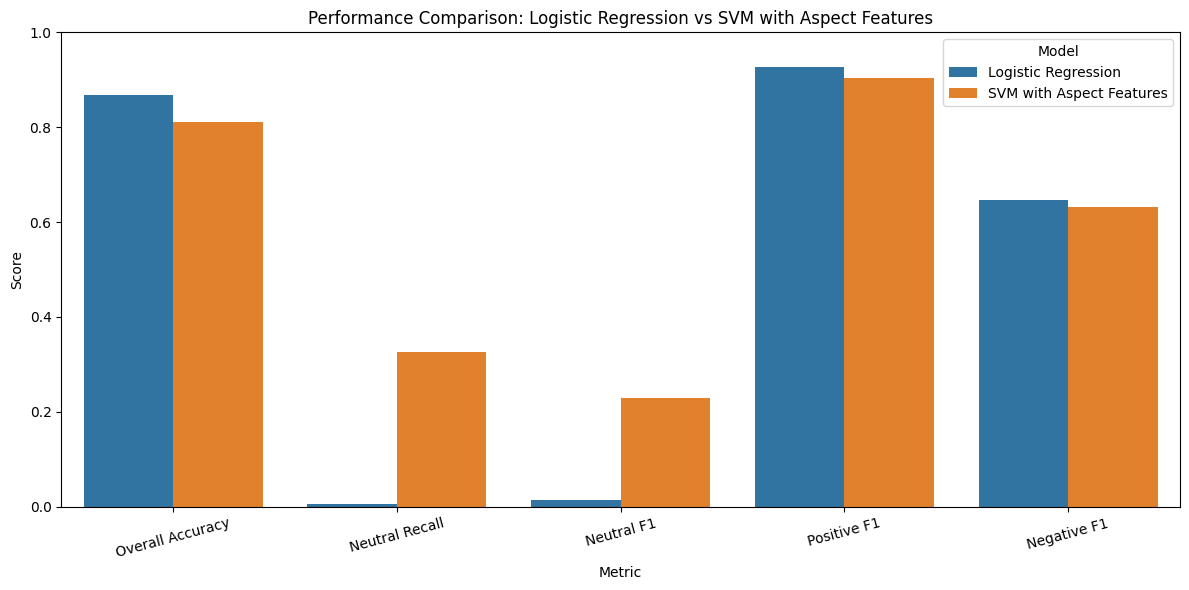


Key SVM Improvements over Logistic Regression:
- Neutral Recall: 4700.0% improvement
- Neutral F1 Score: 1615.1% improvement

Direct Comparison of Model Predictions:
Review: The product is just slightly too small for my dryer but still works....
True sentiment: positive
Logistic Regression prediction: positive
SVM prediction: neutral
--------------------------------------------------------------------------------
Review: It’s a cheap replacement. I thought we were getting lucky instead of paying this price for just one ...
True sentiment: negative
Logistic Regression prediction: positive
SVM prediction: negative
--------------------------------------------------------------------------------
Review: These heating elements are easily replaceable on my model of dryer, and much cheaper than buying fro...
True sentiment: positive
Logistic Regression prediction: positive
SVM prediction: neutral
--------------------------------------------------------------------------------
Review: These s

In [12]:
#--------------------------------------------------------------#
# SECTION 8: MODEL COMPARISON
#--------------------------------------------------------------#
print("\nSECTION 8: MODEL COMPARISON")

# Calculate class-specific metrics for both models
lr_report = classification_report(y_test, y_pred_lr, output_dict=True)
svm_report = classification_report(y_test, svm_y_pred, output_dict=True)

# Create a comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'SVM with Aspect Features'],
    'Overall Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, svm_y_pred)],
    'Neutral Precision': [lr_report['neutral']['precision'], svm_report['neutral']['precision']],
    'Neutral Recall': [lr_report['neutral']['recall'], svm_report['neutral']['recall']],
    'Neutral F1': [lr_report['neutral']['f1-score'], svm_report['neutral']['f1-score']],
    'Positive F1': [lr_report['positive']['f1-score'], svm_report['positive']['f1-score']],
    'Negative F1': [lr_report['negative']['f1-score'], svm_report['negative']['f1-score']]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(comparison_df)

# Create a bar chart to visualize the comparison
metrics = ['Overall Accuracy', 'Neutral Recall', 'Neutral F1', 'Positive F1', 'Negative F1']
comparison_plot = pd.melt(comparison_df, id_vars=['Model'], value_vars=metrics, 
                        var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_plot)
plt.title('Performance Comparison: Logistic Regression vs SVM with Aspect Features')
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Calculate improvement percentages
neutral_recall_improvement = ((svm_report['neutral']['recall'] - lr_report['neutral']['recall']) / 
                             max(lr_report['neutral']['recall'], 0.001)) * 100
neutral_f1_improvement = ((svm_report['neutral']['f1-score'] - lr_report['neutral']['f1-score']) / 
                         max(lr_report['neutral']['f1-score'], 0.001)) * 100

print("\nKey SVM Improvements over Logistic Regression:")
print(f"- Neutral Recall: {neutral_recall_improvement:.1f}% improvement")
print(f"- Neutral F1 Score: {neutral_f1_improvement:.1f}% improvement")

# Direct comparison of predictions
print("\nDirect Comparison of Model Predictions:")
mismatch_idx = np.where(y_pred_lr != svm_y_pred)[0]
if len(mismatch_idx) > 0:
    sample_mismatch = np.random.choice(mismatch_idx, min(5, len(mismatch_idx)), replace=False)
    for idx in sample_mismatch:
        text = X_test.iloc[idx]
        true_label = y_test.iloc[idx]
        lr_pred = y_pred_lr[idx]
        svm_pred = svm_y_pred[idx]
        print(f"Review: {text[:100]}...")  # Show first 100 chars
        print(f"True sentiment: {true_label}")
        print(f"Logistic Regression prediction: {lr_pred}")
        print(f"SVM prediction: {svm_pred}")
        print("-" * 80)


SECTION 9: RECOMMENDATION SYSTEM WITH SENTIMENT ANALYSIS
Best parameters: {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}
Best RMSE: 1.3750242138820525
RMSE: 1.3869
RMSE of recommendation model: 1.3869
Preparing data for recommendation system...
Creating hybrid recommendation model...

Sample Recommendations:

Top 5 Recommendations for User AH76W3Z2SV6WJ6GLB35SM7SDQ54Q:
1. Product B01KJ2FVFW - Fits my Cuisinart K cup coffee maker perfectly. (Predicted Rating: 4.59)
2. Product B07JK1HM6P - Quick delivery for replacment switch (Predicted Rating: 4.46)
3. Product B08JP39RLP - Capable of sending data from tough to reach locations. (Predicted Rating: 4.45)
4. Product B01JAC77TA - No use (Predicted Rating: 4.44)
5. Product B078Z4LMP1 - Good . (Predicted Rating: 4.44)

Users similar to AH76W3Z2SV6WJ6GLB35SM7SDQ54Q:
User AH76W3Z2SV6WJ6GLB35SM7SDQ54Q not found in training set

Top 5 Recommendations for User AF365FLQZATDKEJ4SADPMGVKEHVA:
Best parameters: {'n_factors': 100, 

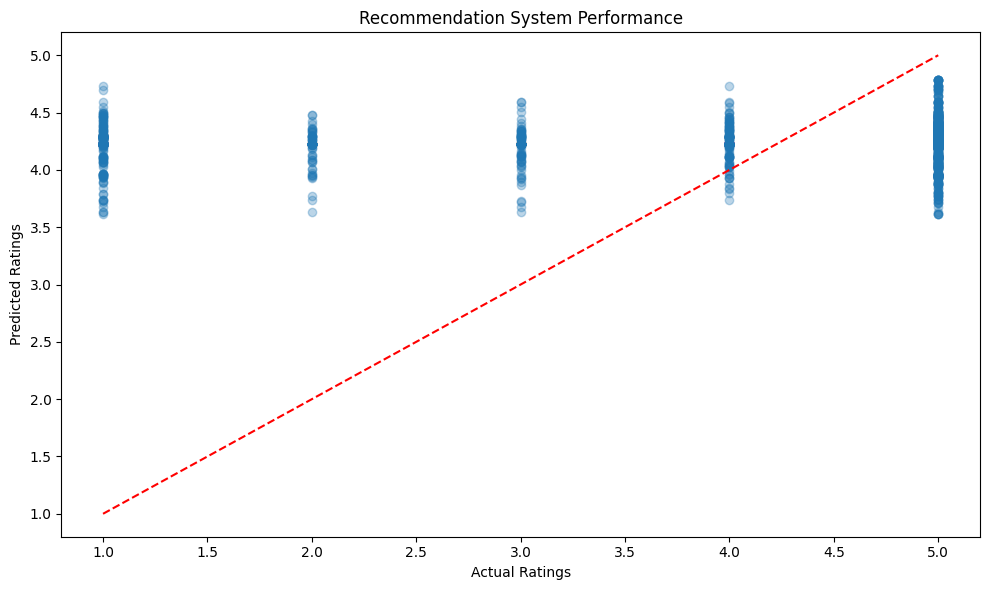

In [ ]:
#--------------------------------------------------------------#
# SECTION 9: RECOMMENDATION SYSTEM WITH SENTIMENT ANALYSIS
#--------------------------------------------------------------#
print("\nSECTION 9: RECOMMENDATION SYSTEM WITH SENTIMENT ANALYSIS")

# Install required libraries if not already installed
import sys
!{sys.executable} -m pip install surprise

# Import necessary libraries for recommendation system
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy
from surprise.model_selection import GridSearchCV

# Define parameter grid for GridSearchCV
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.01, 0.02, 0.04]
}

# Create a DataFrame with user_id, product_id, and rating
# For this example, we'll use the product's ASIN as the item_id
recommendation_data = pd.DataFrame({
    'user_id': df['user_id'],
    'item_id': df['asin'],
    'rating': df['rating']
})

# Define Reader for Surprise
reader = Reader(rating_scale=(1, 5))

# Create Surprise dataset from DataFrame
data = Dataset.load_from_df(recommendation_data[['user_id', 'item_id', 'rating']], reader)

# Split into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)

# Now we can use GridSearchCV to find the best parameters for SVD
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
gs_params = gs.best_params['rmse']
print("Best parameters:", gs_params)
print("Best RMSE:", gs.best_score['rmse'])

# Create and train SVD model
# svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
svd_model = gs.best_estimator['rmse']
svd_model.fit(trainset)

# Test the model
predictions = svd_model.test(testset)
rmse = accuracy.rmse(predictions)
print(f"RMSE of recommendation model: {rmse:.4f}")

# Function to convert sentiment predictions to numerical ratings
def sentiment_to_rating(sentiment):
    """
    Convert sentiment predictions to numerical ratings
    positive: 4-5
    neutral: 3
    negative: 1-2
    """
    if sentiment == 'positive':
        return 4.5  # Average between 4-5
    elif sentiment == 'neutral':
        return 3.0
    else:  # negative
        return 1.5  # Average between 1-2

# Prepare data for recommendation system
print("Preparing data for recommendation system...")

# Add sentiment-based rating using our best model (SVM)  (Singular Value Decomposition)
# matrix‑factorization–based collaborative filtering algorithm
# First, create a copy of the test data to generate predictions for all reviews
if 'sentiment' not in df.columns:
    print("Adding predicted sentiments for all reviews...")
    # Use the existing trained SVM model to predict sentiments
    # Extract aspects for all reviews
    all_aspects = extract_aspects(df['text'].values, top_n=10)
    
    # Process all reviews using the same aspect-based sentiment analysis
    all_aspect_sentiments = analyze_aspect_sentiment(df['text'].values, all_aspects)
    
    # Create features for all reviews
    X_all_enhanced, _ = create_enhanced_features(df['text'].values, all_aspect_sentiments)
    
    # Predict sentiment for all reviews
    df['sentiment_pred'] = svm_model.predict(X_all_enhanced)
else:
    # If sentiment column already exists, use it
    df['sentiment_pred'] = df['sentiment']

# Add sentiment-based rating
recommendation_data['sentiment_rating'] = df['sentiment_pred'].apply(sentiment_to_rating)

# Use both actual ratings and sentiment-based ratings
print("Creating hybrid recommendation model...")

# Function to get top N recommendations for a user
def get_top_recommendations(user_id, n=5):
    """
    Get top N product recommendations for a specific user
    """
    # Get all product IDs
    all_item_ids = recommendation_data['item_id'].unique()
    
    # Filter out items the user has already rated
    user_rated_items = recommendation_data[recommendation_data['user_id'] == user_id]['item_id'].unique()
    items_to_predict = list(set(all_item_ids) - set(user_rated_items))
    
    # If user hasn't rated anything or all items are rated, return all predictions
    if len(items_to_predict) == 0:
        items_to_predict = all_item_ids
    
    # Make predictions for the user
    predictions = [svd_model.predict(user_id, item_id) for item_id in items_to_predict]
    
    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Return top N recommendations
    return predictions[:n]

# Function to get similar users based on rating patterns
def get_similar_users(user_id, n=5):
    """
    Get N users similar to the specified user based on rating patterns
    """
    # Get user factors from SVD model
    user_factors = pd.DataFrame(svd_model.pu, index=trainset.all_users())
    
    # Convert user_id to internal id used by Surprise
    if user_id in trainset.all_users():
        user_idx = trainset.to_inner_uid(user_id)
        
        # Calculate cosine similarity between this user and all others
        user_vector = user_factors.iloc[user_idx].values.reshape(1, -1)
        similarities = cosine_similarity(user_vector, user_factors)[0]
        
        # Create a DataFrame of user IDs and their similarity scores
        similar_users = pd.DataFrame({
            'user_id': [trainset.to_raw_uid(idx) for idx in range(len(similarities))],
            'similarity': similarities
        })
        
        # Sort by similarity (excluding the user itself) and return top N
        return similar_users[similar_users['user_id'] != user_id].sort_values(
            'similarity', ascending=False).head(n)
    else:
        print(f"User {user_id} not found in training set")
        return pd.DataFrame()

# Example usage - get recommendations for a few sample users
print("\nSample Recommendations:")
sample_users = df['user_id'].sample(3).tolist() if len(df['user_id'].unique()) > 3 else df['user_id'].unique().tolist()

for user in sample_users:
    print(f"\nTop 5 Recommendations for User {user}:")
    recommendations = get_top_recommendations(user, 5)
    
    for i, rec in enumerate(recommendations):
        # Get the product title if available
        product_id = rec.iid
        product_info = ""
        if 'title' in df.columns:
            product_titles = df[df['asin'] == product_id]['title'].unique()
            if len(product_titles) > 0:
                product_info = f" - {product_titles[0]}"
        
        print(f"{i+1}. Product {product_id}{product_info} (Predicted Rating: {rec.est:.2f})")
    
    # Show similar users
    print(f"\nUsers similar to {user}:")
    similar_users = get_similar_users(user, 3)
    if not similar_users.empty:
        for i, (idx, row) in enumerate(similar_users.iterrows()):
            print(f"{i+1}. User {row['user_id']} (Similarity: {row['similarity']:.4f})")

# Visualize recommendation performance
plt.figure(figsize=(10, 6))
actual_ratings = [pred.r_ui for pred in predictions if pred.r_ui is not None]
predicted_ratings = [pred.est for pred in predictions if pred.r_ui is not None]

plt.scatter(actual_ratings, predicted_ratings, alpha=0.3)
plt.plot([min(actual_ratings), max(actual_ratings)], [min(actual_ratings), max(actual_ratings)], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Recommendation System Performance')
plt.tight_layout()
plt.show()


SECTION 10: OFFLINE EVALUATION OF RECOMMENDER SYSTEM MODEL

1. Standard Accuracy Metrics:
MAE:  1.0795
MSE: 1.9235
RMSE: 1.3869
  • MAE: 1.0795 (Lower is better)
  • MSE: 1.9235 (Lower is better)
  • RMSE: 1.3869 (Lower is better)

2. Ranking Quality Metric:
  • Precision@10: 0.7948 (Higher is better)
    (Items with true rating >= 4.0 are considered relevant)


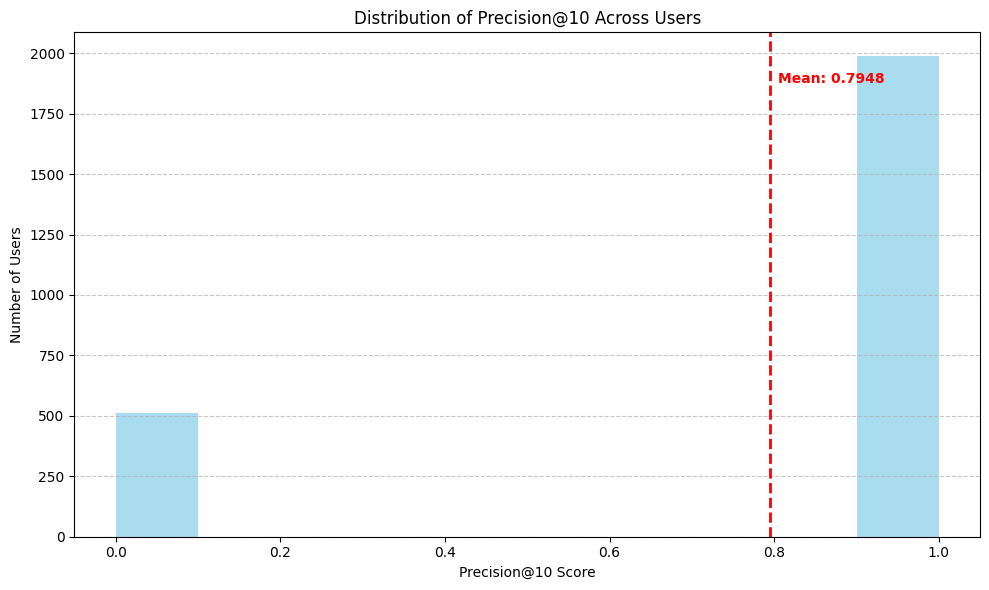


3. Precision@10 Distribution Summary:
  • Minimum: 0.0000
  • Maximum: 1.0000
  • Median: 1.0000
  • Standard deviation: 0.4038


In [ ]:
#--------------------------------------------------------------#
# SECTION 10: OFFLINE EVALUATION OF RECOMMENDER SYSTEM MODEL
#--------------------------------------------------------------#
print("\nSECTION 10: OFFLINE EVALUATION OF RECOMMENDER SYSTEM MODEL")

# Import necessary libraries for evaluation
from surprise import accuracy
from collections import defaultdict
import numpy as np

# Step 1: Calculate standard accuracy metrics
# These metrics measure the difference between predicted and actual ratings
print("\n1. Standard Accuracy Metrics:")
mae = accuracy.mae(predictions)  # Mean Absolute Error
mse = accuracy.mse(predictions)  # Mean Squared Error
rmse = accuracy.rmse(predictions)  # Root Mean Squared Error
print(f"  • MAE: {mae:.4f} (Lower is better)")
print(f"  • MSE: {mse:.4f} (Lower is better)")
print(f"  • RMSE: {rmse:.4f} (Lower is better)")

# Step 2: Calculate Precision@k (a ranking metric)
# This measures how many of the top-k recommended items are actually relevant

# Set parameters for precision calculation
k = 10  # Number of top recommendations to consider
relevance_threshold = 4.0  # Items with true rating >= this are considered relevant

# Group predictions by user
user_predictions = defaultdict(list)
for pred in predictions:
    # Only consider predictions where we know the true rating (r_ui is not None)
    if pred.r_ui is not None:
        user_predictions[pred.uid].append(pred)

# Calculate precision@k for each user
precision_at_k_scores = []
for uid, user_preds in user_predictions.items():
    # Sort user's predictions by estimated rating (highest first)
    user_preds.sort(key=lambda x: x.est, reverse=True)
        
    # Take top k predictions
    top_k_preds = user_preds[:k] if len(user_preds) >= k else user_preds
    
    # Count relevant items in top k
    n_relevant = sum(1 for pred in top_k_preds if pred.r_ui >= relevance_threshold)
    
    # Calculate precision@k for this user
    precision_at_k = n_relevant / len(top_k_preds)
    precision_at_k_scores.append(precision_at_k)

# Calculate average precision@k across all users
avg_precision_at_k = np.mean(precision_at_k_scores) if precision_at_k_scores else 0

print(f"\n2. Ranking Quality Metric:")
print(f"  • Precision@{k}: {avg_precision_at_k:.4f} (Higher is better)")
print(f"    (Items with true rating >= {relevance_threshold} are considered relevant)")

# Step 3: Additional analysis - Distribution of precision scores
if precision_at_k_scores:
    plt.figure(figsize=(10, 6))
    plt.hist(precision_at_k_scores, bins=10, alpha=0.7, color='skyblue')
    plt.axvline(avg_precision_at_k, color='red', linestyle='dashed', linewidth=2)
    plt.text(avg_precision_at_k+0.01, plt.ylim()[1]*0.9, f'Mean: {avg_precision_at_k:.4f}', 
             color='red', fontweight='bold')
    plt.xlabel(f'Precision@{k} Score')
    plt.ylabel('Number of Users')
    plt.title(f'Distribution of Precision@{k} Across Users')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(f"\n3. Precision@{k} Distribution Summary:")
    print(f"  • Minimum: {np.min(precision_at_k_scores):.4f}")
    print(f"  • Maximum: {np.max(precision_at_k_scores):.4f}")
    print(f"  • Median: {np.median(precision_at_k_scores):.4f}")
    print(f"  • Standard deviation: {np.std(precision_at_k_scores):.4f}")